In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

print(f'Using device {device}')

Using device cpu


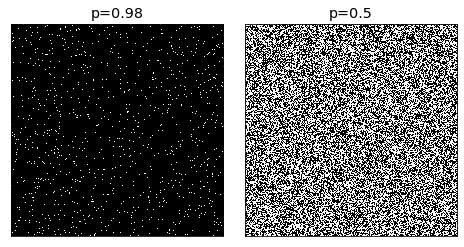

In [3]:
from utils import *
mask = torch.from_numpy(get_bernoulli_mask((3,500,500), 0.98))
mask[1] = mask[0]
mask[2] = mask[0]
mask2 = torch.from_numpy(get_bernoulli_mask((3,256,256), 0.5))
mask2[1] = mask2[0]
mask2[2] = mask2[0]
fig, axes = tensors_as_images([mask, mask2], 
                                        titles=['p=0.98', 'p=0.5'])

In [52]:
from models import *
from models.unet import *
# Change IMAGE to jet for jet image or snail for snail image
IMAGE = 'kate'

input_depth = 32
if IMAGE == 'barbara':
    net = UNet(input_depth, 1, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
elif IMAGE == 'kate':
    net = UNet(input_depth, 3, [16, 32, 64, 128, 128], [16, 32, 64, 128, 128], [0]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
else:
    assert False
net.to(device)
print(f'Image is {IMAGE}')
#print(net)

Image is kate


In [53]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 1332531


Image dim : (3, 512, 512)


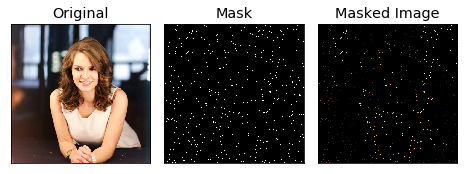

In [54]:
from utils import *
from input_gen import *

reg_noise_std = 1./30.
fname_barbara = 'data/restoration/barbara.png'
fname_kate = 'data/restoration/kate.png'
fname = fname_barbara if IMAGE == 'barbara' else fname_kate
use_noise = False if IMAGE == 'barbara' else True
img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np).type(torch.FloatTensor)
if IMAGE == 'barbara':
    img_mask_np = get_bernoulli_mask(img_np.shape, 0.5)
elif IMAGE == 'kate':
    img_mask_np = get_bernoulli_mask(img_np.shape, 0.98)
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
img_tr = torch.from_numpy(img_np).type(torch.FloatTensor)
mask_tr = torch.from_numpy(img_mask_np).type(torch.FloatTensor)
img_masked = img_np * img_mask_np
img_masked_tr = torch.from_numpy(img_masked).type(torch.FloatTensor)
print(f'Image dim : {img_np.shape}')
fig, axes = tensors_as_images([img_tr, mask_tr, img_masked_tr],
                              titles=['Original', 'Mask', 'Masked Image'],
                              cmap='Greys', figsize=(16,16))


In [58]:
target_img = img_masked_tr
target_img = target_img.unsqueeze(dim=0).to(device)
net_input = get_noise(input_depth, *img_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()

# HyperParmaters for each image
if IMAGE == 'barbara':
    LR = 0.001
    num_iter = 11000
    reg_noise_std = 0.03
elif IMAGE == 'kate':
    LR = 0.01
    num_iter = 1000
    reg_noise_std = 0
    
if reg_noise_std > 0:
        net_input = net_input + (noise.normal_() * reg_noise_std)
print(f'Hyperparameters : LR = {LR},  num_iter = {num_iter},  std = {reg_noise_std}')

Hyperparameters : LR = 0.01,  num_iter = 1000,  std = 0


C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  # This is added back by InteractiveShellApp.init_path()


Iteration  50   Loss = 0.000345   PSNR masked = 34.626036   PSNR = 17.336813 
Iteration  100   Loss = 0.000194   PSNR masked = 37.110991   PSNR = 19.484702 
Iteration  150   Loss = 0.000132   PSNR masked = 38.795124   PSNR = 20.877483 
Iteration  200   Loss = 0.000101   PSNR masked = 39.958807   PSNR = 21.630526 
Iteration  250   Loss = 0.000073   PSNR masked = 41.368579   PSNR = 22.570969 
Iteration  300   Loss = 0.000074   PSNR masked = 41.312716   PSNR = 22.554139 
Iteration  350   Loss = 0.000052   PSNR masked = 42.826913   PSNR = 23.282918 
Iteration  400   Loss = 0.000045   PSNR masked = 43.474690   PSNR = 23.575047 
Iteration  450   Loss = 0.000040   PSNR masked = 43.972039   PSNR = 23.828930 
Iteration  500   Loss = 0.000035   PSNR masked = 44.538495   PSNR = 24.005691 
Iteration  550   Loss = 0.000030   PSNR masked = 45.259999   PSNR = 24.286309 
Iteration  600   Loss = 0.000033   PSNR masked = 44.856423   PSNR = 24.111145 
Iteration  650   Loss = 0.000026   PSNR masked = 45.7

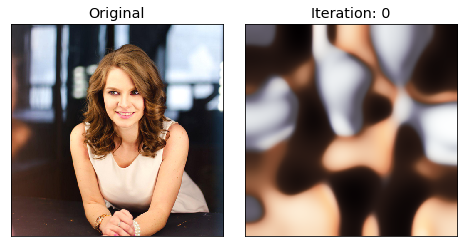

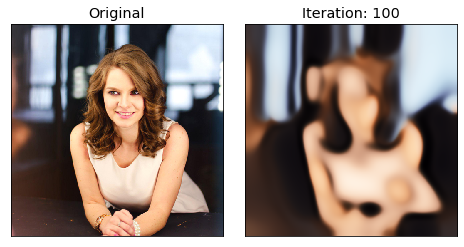

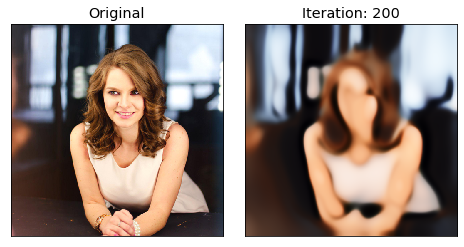

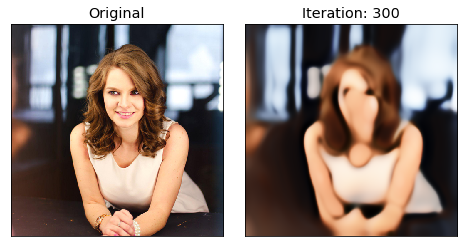

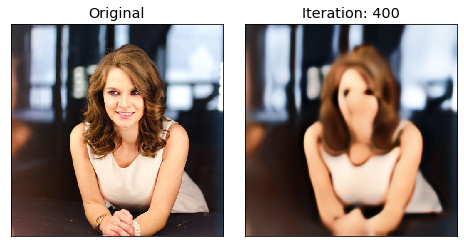

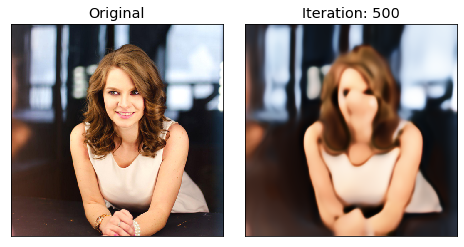

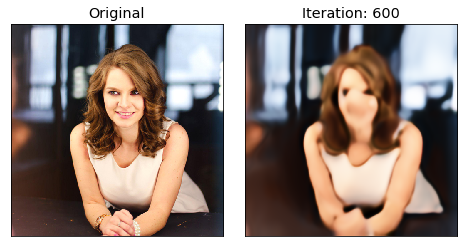

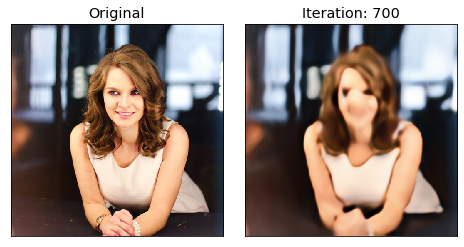

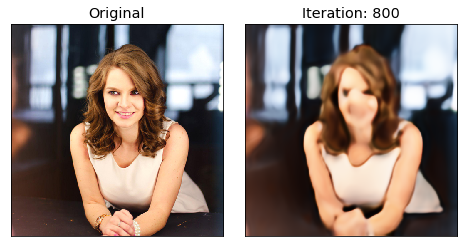

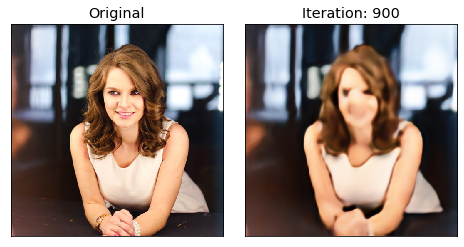

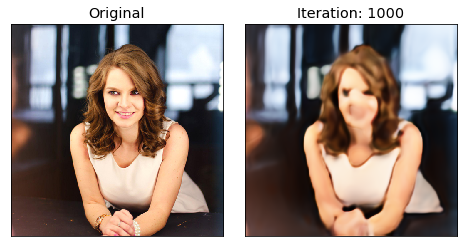

In [59]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
show_every = 50
optimizer = torch.optim.Adam(parameters, lr=LR)
for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out * mask_tr.unsqueeze(dim=0), target_img)
    loss.backward()
    psnr_masked = peak_signal_noise_ratio(target_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0] * img_mask_np)
    psnr = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    
    optimizer.step()
    print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
          (i, loss.item(), psnr_masked, psnr), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
              (i, loss.item(), psnr_masked, psnr))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                      titles=['Original', f'Iteration: {i}'], cmap='Greys')
print(f'Done training final Loss = {loss.item()}   PSNR masked= {psnr_masked}   PSNR = {psnr}')
fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                    titles=['Original', f'Iteration: {num_iter}'], cmap='Greys')

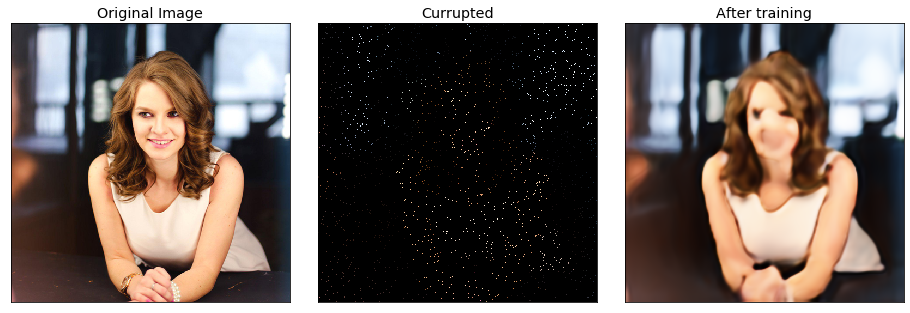

In [60]:
# Showing result of the training using original noise and random noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, target_img[0], output], 
                                        titles=['Original Image', 'Currupted', 'After training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}.png')
# will need to use original noise to do denoising

 Best PSNR = 24.600154   Best p = 0.004500


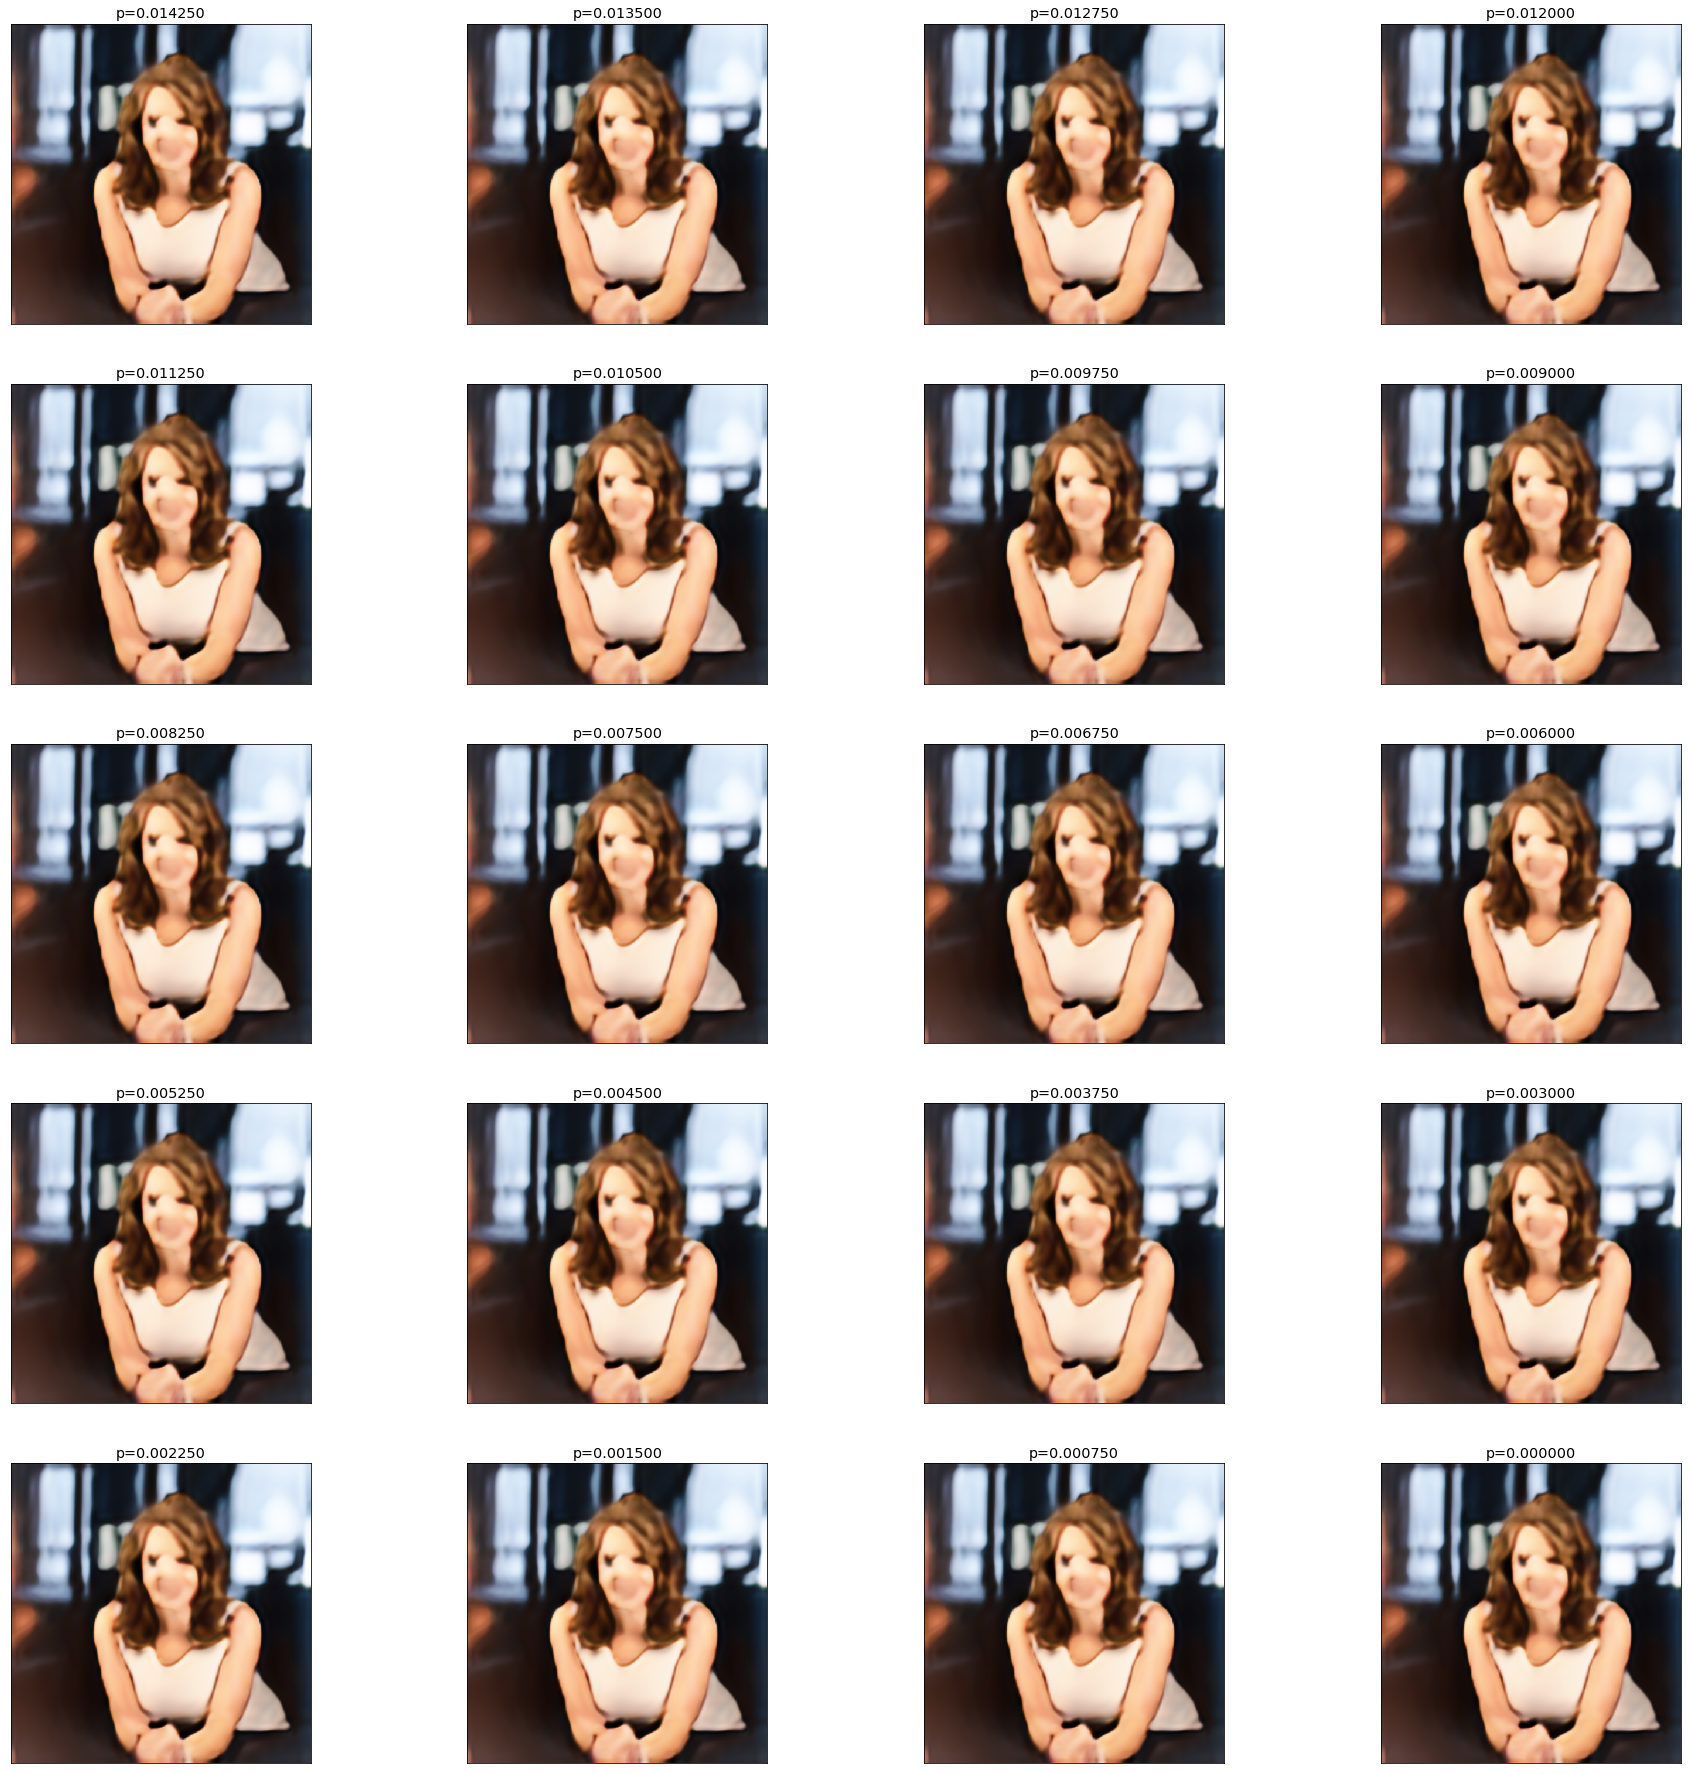

In [69]:
# Try to get better results by changing z_input a bit
with torch.no_grad():
    a = torch.rand(*original_noise.shape)  
    best_psnr = 0
    best_p = 0
    results = []
    values = list(np.arange(0.000, 0.015,0.015/20))
    for p in reversed(values):
        a[abs(a) > p] = 0
        new_noise = original_noise + a.to(device)
        output = net(new_noise).detach()
        psnr    = peak_signal_noise_ratio(img_np, output.detach().cpu().numpy()[0]) 
        output = output.squeeze(dim=0)
        results.append(output.clone())
        if psnr > best_psnr:
            best_psnr = psnr
            best_p = p
    print(f' Best PSNR = %f   Best p = %f' % (best_psnr, best_p))
    nrows = int(len(values)/4)
    fig, axes = tensors_as_images(results, titles=[f'p=%f' % p for p in reversed(values)],
                                        nrows=nrows, figsize=(32,32), cmap='Greys')
        